
### Customer Clustering – EastWestAirlines

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from itertools import product

#Plot settings
plt.rcParams["figure.figsize"]=(8,5)
plt.rcParams["axes.grid"]=True

#### 1) Load the dataset

In [2]:
excel_path="EastWestAirlines.xlsx"
csv_path="EastWestAirlines.csv"

#Read the second sheet (real dataset has headers in first row)
df_excel=pd.read_excel(excel_path,sheet_name=1)

#Save to CSV
df_excel.to_csv(csv_path,index=False)
print("CSV saved to:",csv_path)

#Load from CSV
df_raw=pd.read_csv(csv_path)
df=df_raw.copy()
print("Loaded dataset shape:",df.shape)
df.head()

CSV saved to: EastWestAirlines.csv
Loaded dataset shape: (3999, 12)


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


#### 2) Quick data overview

In [3]:
#Basic EDA
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   ID#                3999 non-null   int64
 1   Balance            3999 non-null   int64
 2   Qual_miles         3999 non-null   int64
 3   cc1_miles          3999 non-null   int64
 4   cc2_miles          3999 non-null   int64
 5   cc3_miles          3999 non-null   int64
 6   Bonus_miles        3999 non-null   int64
 7   Bonus_trans        3999 non-null   int64
 8   Flight_miles_12mo  3999 non-null   int64
 9   Flight_trans_12    3999 non-null   int64
 10  Days_since_enroll  3999 non-null   int64
 11  Award?             3999 non-null   int64
dtypes: int64(12)
memory usage: 375.0 KB


In [4]:
df.isna().sum()

ID#                  0
Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64

In [5]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
ID#,3999.0,2014.819455,1160.764358,1.0,1010.5,2016.0,3020.5,4021.0
Balance,3999.0,73601.327582,100775.664958,0.0,18527.5,43097.0,92404.0,1704838.0
Qual_miles,3999.0,144.114529,773.663804,0.0,0.0,0.0,0.0,11148.0
cc1_miles,3999.0,2.059515,1.376919,1.0,1.0,1.0,3.0,5.0
cc2_miles,3999.0,1.014504,0.147650,1.0,1.0,1.0,1.0,3.0
cc3_miles,3999.0,1.012253,0.195241,1.0,1.0,1.0,1.0,5.0
Bonus_miles,3999.0,17144.846212,24150.967826,0.0,1250.0,7171.0,23800.5,263685.0
Bonus_trans,3999.0,11.601900,9.603810,0.0,3.0,12.0,17.0,86.0
Flight_miles_12mo,3999.0,460.055764,1400.209171,0.0,0.0,0.0,311.0,30817.0
Flight_trans_12,3999.0,1.373593,3.793172,0.0,0.0,0.0,1.0,53.0


In [6]:
df.corr()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
ID#,1.000000,-0.243737,-0.019374,-0.224465,0.020291,-0.014707,-0.203012,-0.146915,-0.031013,-0.052096,-0.964988,-0.177901
Balance,-0.243737,1.000000,0.108722,0.338344,-0.008804,0.035243,0.403487,0.324935,0.217551,0.255700,0.263129,0.178494
Qual_miles,-0.019374,0.108722,1.000000,0.007931,-0.013923,-0.007779,0.031021,0.050725,0.126774,0.144004,0.017312,0.095256
cc1_miles,-0.224465,0.338344,0.007931,1.000000,-0.068223,0.060555,0.825200,0.608943,0.037370,0.041333,0.230849,0.335457
cc2_miles,0.020291,-0.008804,-0.013923,-0.068223,1.000000,-0.006166,-0.003969,0.064399,0.010598,0.028284,-0.005807,0.005332
cc3_miles,-0.014707,0.035243,-0.007779,0.060555,-0.006166,1.000000,0.204134,0.097313,-0.001777,-0.001117,0.010832,0.023484
Bonus_miles,-0.203012,0.403487,0.031021,0.825200,-0.003969,0.204134,1.000000,0.603180,0.183536,0.185261,0.210397,0.373506
Bonus_trans,-0.146915,0.324935,0.050725,0.608943,0.064399,0.097313,0.603180,1.000000,0.377216,0.432364,0.161262,0.333893
Flight_miles_12mo,-0.031013,0.217551,0.126774,0.037370,0.010598,-0.001777,0.183536,0.377216,1.000000,0.869193,0.037271,0.217715
Flight_trans_12,-0.052096,0.255700,0.144004,0.041333,0.028284,-0.001117,0.185261,0.432364,0.869193,1.000000,0.059260,0.247909


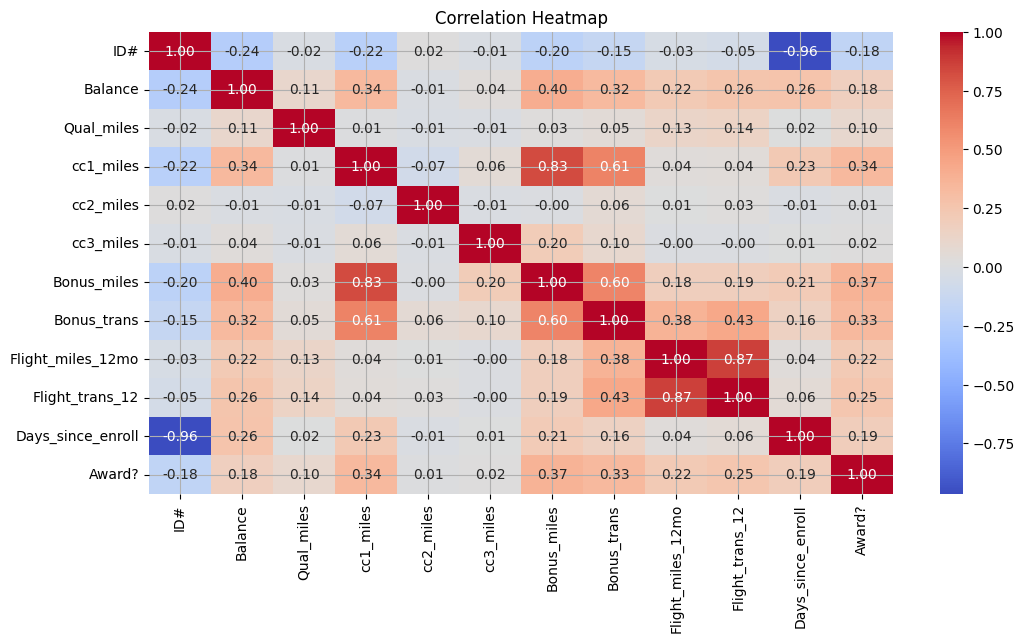

In [7]:
#Correlation heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), cmap="coolwarm", annot=True,fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Histograms of features:


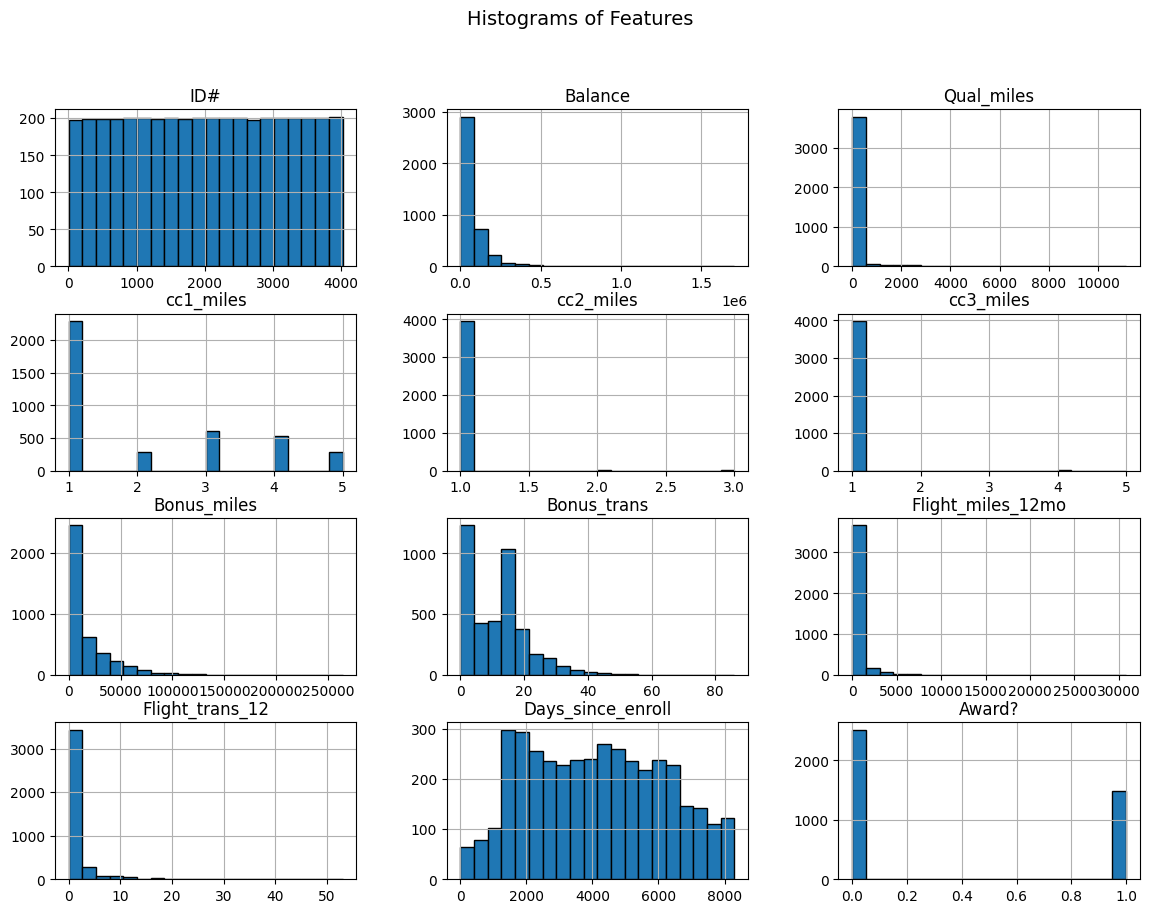

Boxplots of features:


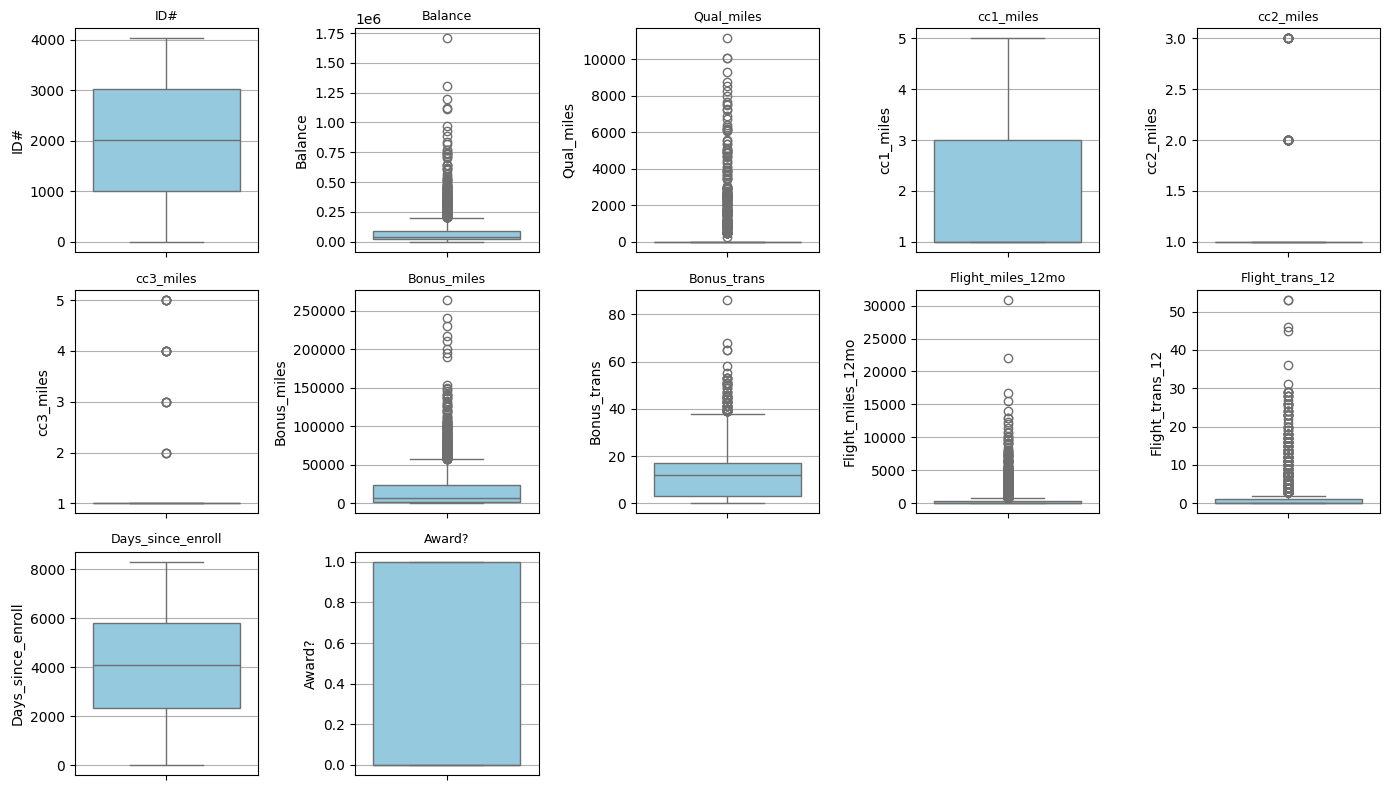

Pairplot of first 5 features:


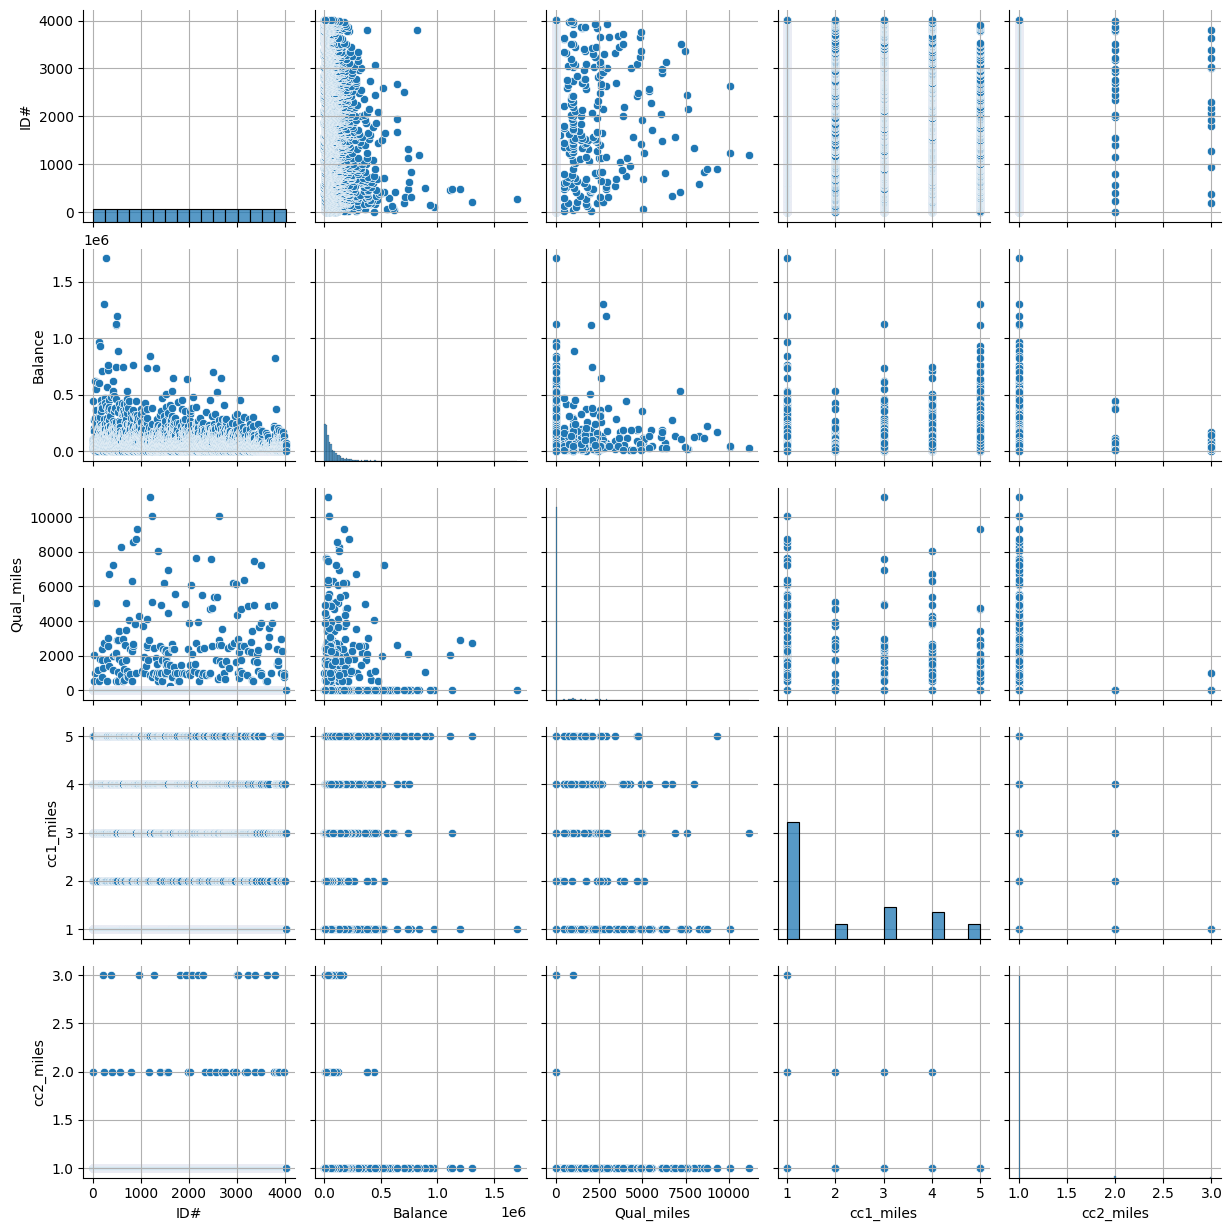

In [8]:
#Data Exploration with Visualizations 

#Histograms for all numeric features
print("Histograms of features:")
df.hist(bins=20,figsize=(14,10),edgecolor='black')
plt.suptitle("Histograms of Features",fontsize=14)
plt.show()

#Boxplots for all numeric features
print("Boxplots of features:")
plt.figure(figsize=(14,8))
for i, col in enumerate(df.columns, 1):
    plt.subplot(3,5,i)   # adjust rows/cols depending on total features
    sns.boxplot(y=df[col],color="skyblue")
    plt.title(col,fontsize=9)
plt.tight_layout()
plt.show()

#Pairplot for a subset of variables (to avoid overcrowding)
subset_cols=df.columns[:5]  # first 5 columns for readability
print("Pairplot of first 5 features:")
sns.pairplot(df[subset_cols])
plt.show()


#### 3) Data preprocessing
Steps:
1. Drop unnecessary columns.
2. Outlier handling using IQR-based capping.
3. Scale the features using `StandardScaler`.


In [9]:
#Since all columns are numeric (int64), no need to split and you can use them all for clustering.
#Drop ID# since it's just an identifier
X=df.drop(columns=["ID#"]).copy()
print("Columns used for clustering:",X.columns.tolist())
X.head()

Columns used for clustering: ['Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles', 'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12', 'Days_since_enroll', 'Award?']


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,28143,0,1,1,1,174,1,0,0,7000,0
1,19244,0,1,1,1,215,2,0,0,6968,0
2,41354,0,1,1,1,4123,4,0,0,7034,0
3,14776,0,1,1,1,500,1,0,0,6952,0
4,97752,0,4,1,1,43300,26,2077,4,6935,1


In [10]:
X.drop(columns=["Award?"],inplace=True)
X.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
0,28143,0,1,1,1,174,1,0,0,7000
1,19244,0,1,1,1,215,2,0,0,6968
2,41354,0,1,1,1,4123,4,0,0,7034
3,14776,0,1,1,1,500,1,0,0,6952
4,97752,0,4,1,1,43300,26,2077,4,6935


In [11]:
#Outlier capping (IQR) and scaling
X_capped=X.copy()
for col in X_capped.columns:
    Q1=X_capped[col].quantile(0.25)
    Q3=X_capped[col].quantile(0.75)
    IQR=Q3-Q1
    lower=Q1-1.5*IQR
    upper=Q3+1.5*IQR
    X_capped[col]=X_capped[col].clip(lower,upper)

scaler=StandardScaler()
X_scaled=pd.DataFrame(scaler.fit_transform(X_capped),columns=X_capped.columns,index=X_capped.index)

print("Preprocessing complete(IQR capping + Standard scaling).")
display(X_scaled.head())

Preprocessing complete(IQR capping + Standard scaling).


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
0,-0.607258,0.0,-0.769578,0.0,0.0,-0.843091,-1.148854,-0.604313,-0.626143,1.395454
1,-0.758947,0.0,-0.769578,0.0,0.0,-0.840822,-1.039133,-0.604313,-0.626143,1.379957
2,-0.382070,0.0,-0.769578,0.0,0.0,-0.624581,-0.819689,-0.604313,-0.626143,1.411920
3,-0.835106,0.0,-0.769578,0.0,0.0,-0.825052,-1.148854,-0.604313,-0.626143,1.372208
4,0.579265,0.0,1.409471,0.0,0.0,1.543191,1.594189,2.034489,2.020176,1.363975


In [12]:
#PCA for 2D visualization (keeps for all visualizations)
pca=PCA(n_components=2,random_state=42)
X_pca=pca.fit_transform(X_scaled)
print("PCA explained variance ratio (2 components):",pca.explained_variance_ratio_)

PCA explained variance ratio (2 components): [0.46098447 0.24322009]


In [13]:
#helper for plotting clusters in PCA space
def plot_pca_clusters(labels,title="Clusters (PCA 2D)"):
    plt.figure(figsize=(8,6))
    unique=np.unique(labels)
    #color -1 (noise) specially if present
    palette=sns.color_palette("tab10",n_colors=max(1,len(unique)))
    sns.scatterplot(x=X_pca[:,0],y=X_pca[:,1],hue=labels,palette=palette,legend="full",s=40)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## 4) K-Means clustering
- Exploring different values of K using the Elbow method (inertia) and Silhouette score.

In [14]:
#4)K-Means Clustering
#Try K values from 2-10 and check both inertia(Elbow method) and silhouette scores to decide the best number of clusters
Ks=list(range(2,11))
inertias=[]
sil_scores=[]

for k in Ks:
    kmeans_temp=KMeans(n_clusters=k,n_init=20,random_state=42)
    labels_temp=kmeans_temp.fit_predict(X_scaled)

    # inertia tells how close the points are to their cluster centers (lower = better)
    inertias.append(kmeans_temp.inertia_)

    # silhouette tells how well separated the clusters are (higher = better)
    sil_scores.append(silhouette_score(X_scaled, labels_temp))

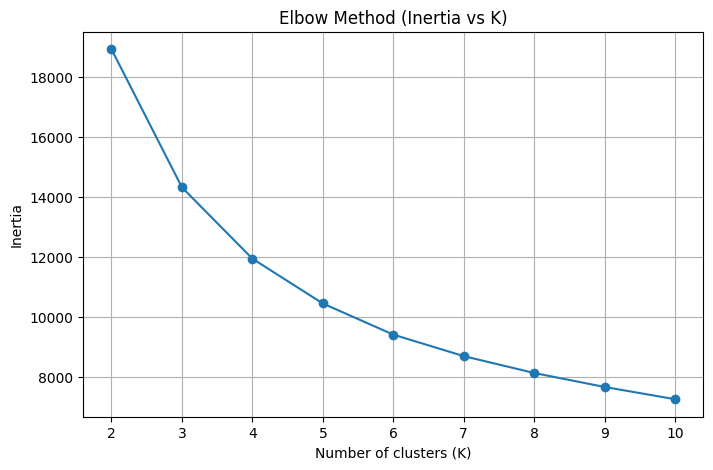

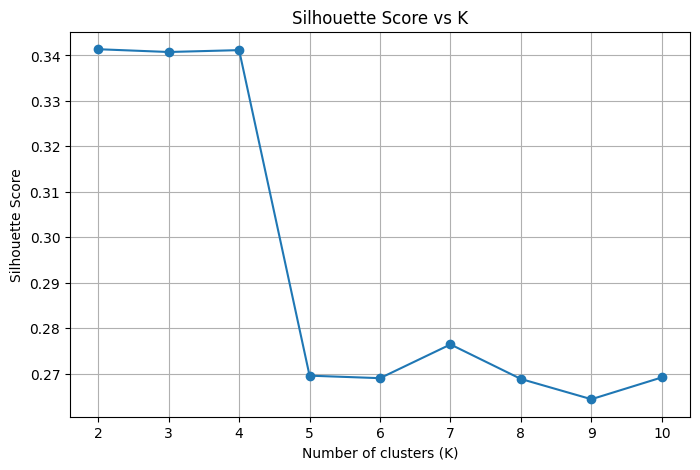

In [15]:
plt.figure()
plt.plot(Ks, inertias, marker='o')
plt.title("Elbow Method (Inertia vs K)")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.show()

# Plot silhouette scores
plt.figure()
plt.plot(Ks, sil_scores, marker='o')
plt.title("Silhouette Score vs K")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()

In [16]:
#From silhouette, pick the best K
best_k=Ks[np.argmax(sil_scores)]
print(f"Best K based on silhouette: {best_k} (score = {max(sil_scores):.4f})")


Best K based on silhouette: 2 (score = 0.3414)


In [17]:
#Now run KMeans with this best K
kmeans=KMeans(n_clusters=best_k, n_init=20, random_state=42)
km_labels=kmeans.fit_predict(X_scaled)

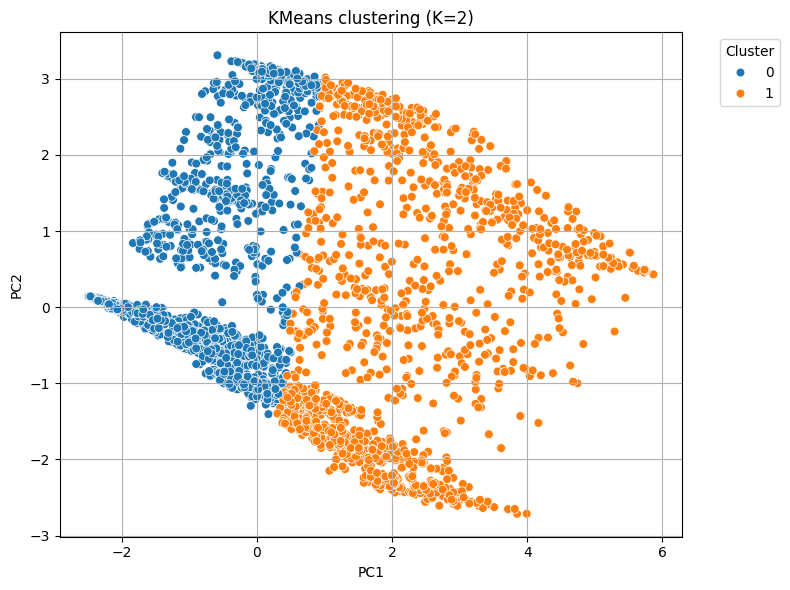

Final silhouette score for KMeans: 0.341377571254098


In [18]:
#Plot in PCA 2D
plot_pca_clusters(km_labels, title=f"KMeans clustering (K={best_k})")

#Print silhouette score
print("Final silhouette score for KMeans:", silhouette_score(X_scaled, km_labels))

In [19]:
#Cluster centers (back to original scale so we can interpret them)
km_centers_scaled = kmeans.cluster_centers_
km_centers_original = pd.DataFrame(scaler.inverse_transform(km_centers_scaled),
                                   columns=X_scaled.columns)
print("KMeans cluster centers (in original units):")
display(km_centers_original)

# Save the labels in our dataframe
df["kmeans_cluster"] = km_labels

KMeans cluster centers (in original units):


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
0,39842.852260,0.0,1.309981,1.0,1.0,5268.747363,7.280603,105.020716,0.365348,3695.906215
1,111032.739397,0.0,3.540179,1.0,1.0,35445.675409,19.747768,322.332217,1.038318,4953.488095


## 5) Hierarchical clustering (Agglomerative)
We try multiple **linkage** strategies: `ward`, `complete`, `average`.  
We pick the one with the highest silhouette among a few cluster counts.

In [21]:
#5)Hierarchical Clustering (Agglomerative)
#Try different linkages (ward, complete, average) and also try different values of k (number of clusters)
linkages=["ward","complete","average"]
Ks_h=range(2, 8)   # from 2 to 7 clusters

best_score=-1
best_cfg=None
best_h_labels=None

for link in linkages:
    for k in Ks_h:
        #build the model
        hc=AgglomerativeClustering(n_clusters=k,linkage=link)
        labels=hc.fit_predict(X_scaled)

        # we need at least 2 clusters to calculate silhouette
        if len(np.unique(labels))>1:
            score=silhouette_score(X_scaled,labels)

            # check if this is better than what we have till now
            if score>best_score:
                best_score=score
                best_cfg=(link, k)
                best_h_labels=labels

print("Best hierarchical config:", best_cfg, "with silhouette score:", best_score)


Best hierarchical config: ('average', 2) with silhouette score: 0.34467606659270833


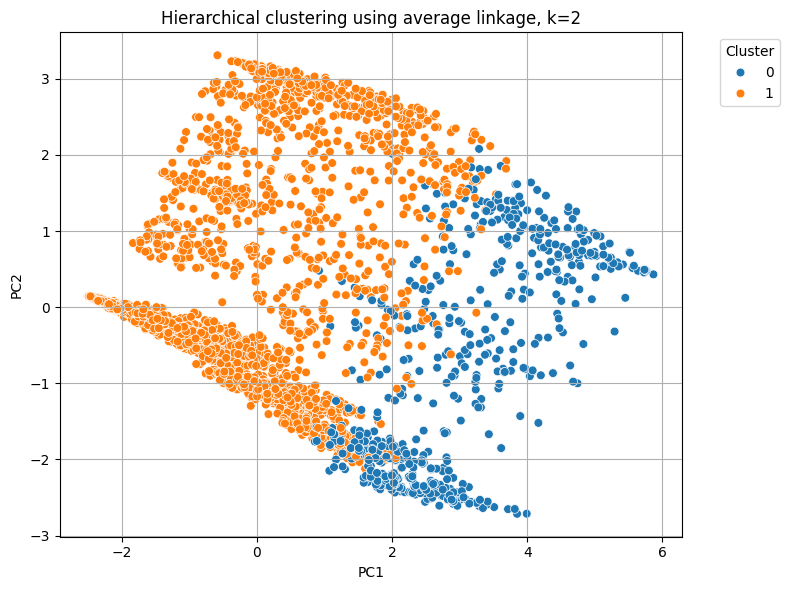

In [22]:
#Plot the clusters (in PCA reduced 2D space)
plot_pca_clusters(best_h_labels,title=f"Hierarchical clustering using {best_cfg[0]} linkage, k={best_cfg[1]}")

#Save the cluster labels into our dataframe
df["hier_cluster"]=best_h_labels


## 6) DBSCAN clustering
We scan a small grid of `eps` and `min_samples` and report the best **silhouette score** (ignoring runs that yield a single cluster or all noise).


In [23]:
#6)DBSCAN Clustering
#DBSCAN needs 2 parameters: eps (neighborhood size) and min_samples (minimum points to form a cluster)
#Try a grid of values to see which one gives the best silhouette score
eps_values=np.linspace(0.3, 3.0, 14)   #eps from 0.3 to 3.0
min_samples_values=[3, 5, 8, 10, 15]   #different min_samples values

best_db_score=-1
best_db_cfg=None
best_db_labels=None

for eps in eps_values:
    for ms in min_samples_values:
        db=DBSCAN(eps=eps,min_samples=ms)
        labels=db.fit_predict(X_scaled)

        # DBSCAN sometimes gives noise points (-1). We ignore them for silhouette calculation.
        core_labels=labels[labels!=-1]

        if len(np.unique(core_labels))>=2:   # we need at least 2 clusters
            try:
                score=silhouette_score(X_scaled[labels!=-1],labels[labels!=-1])

                if score>best_db_score:
                    best_db_score=score
                    best_db_cfg=(eps, ms)
                    best_db_labels=labels
            except:
                # in case silhouette fails, just skip
                continue

Best DBSCAN parameters: (np.float64(1.5461538461538462), 3) with silhouette score: 0.2827478623488355


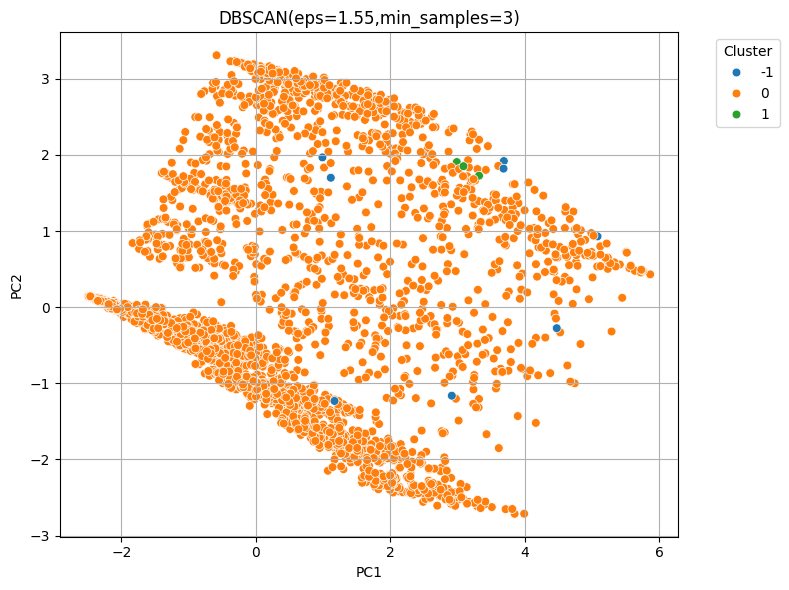

In [24]:
#After trying all eps and min_samples
if best_db_labels is not None:
    print("Best DBSCAN parameters:",best_db_cfg,"with silhouette score:",best_db_score)
    plot_pca_clusters(best_db_labels,title=f"DBSCAN(eps={best_db_cfg[0]:.2f},min_samples={best_db_cfg[1]})")
    df["dbscan_cluster"]=best_db_labels
else:
    print("DBSCAN could not find valid clusters (other than noise).")
    df["dbscan_cluster"]=-1

## 7) Evaluation summary
We collect the **best** silhouette scores from each algorithm for a quick comparison.

In [ ]:
#7) Comparing Silhouette Scores
summary={}

#KMeans score
summary[f"KMeans (k={best_k})"]=silhouette_score(X_scaled,km_labels)

#Hierarchical score
summary[f"Hierarchical ({best_cfg[0]}, k={best_cfg[1]})"]=silhouette_score(X_scaled,best_h_labels)

#DBSCAN score (only if valid clusters exist, not just noise)
if best_db_labels is not None and len(np.unique(best_db_labels[best_db_labels!=-1]))>1:
    summary[f"DBSCAN (eps={best_db_cfg[0]:.2f},min_samples={best_db_cfg[1]})"]=best_db_score

In [26]:
#Print results
print("Silhouette Scores of Different Methods: ")
for method,score in summary.items():
    print(f"{method}: {score:.4f}")

#Just a small conclusion for clarity
best_method=max(summary, key=summary.get)
print(f"Overall,{best_method} gave the best silhouette score.")

Silhouette Scores of Different Methods: 
KMeans (k=2): 0.3414
Hierarchical (average, k=2): 0.3447
DBSCAN (eps=1.55,min_samples=3): 0.2827
Overall,Hierarchical (average, k=2) gave the best silhouette score.


## 8) Cluster analysis & interpretation

Below are brief, high-level insights you can customize after inspecting the cluster profiles/centroids:

- **K-Means:** Clusters show distinct levels on loyalty/flight-usage features (e.g., `Balance`, `Qual_miles`, `Bonus_miles`).  
- **Hierarchical:** With the selected linkage, segments are similar to K-Means but with slightly different boundaries   
- **DBSCAN:** Helps discover dense pockets and mark noise points; best used when clusters are irregularly shaped.

In [27]:
#8)Cluster Profiling(average values of each cluster)

def cluster_profile(label_col):
    print(f"--- Profiling clusters formed by {label_col} ---")
    
    #Bring data back to original scale
    original_scaled=pd.DataFrame(scaler.inverse_transform(X_scaled),columns=X_scaled.columns,index=X_scaled.index)
    
    #Add cluster labels to it
    df_temp=pd.concat([df[label_col],original_scaled],axis=1)
    
    #Show mean values of each cluster
    cluster_means=df_temp.groupby(label_col).mean().round(2)
    display(cluster_means)

#KMeans profile
cluster_profile("kmeans_cluster")

#Hierarchical profile
cluster_profile("hier_cluster")

#DBSCAN profile (ignoring noise = -1)
if "dbscan_cluster" in df.columns:
    print("--- Profiling DBSCAN clusters (ignoring noise points) ---")
    valid=df["dbscan_cluster"] != -1
    if valid.sum()>0:
        original_scaled=pd.DataFrame(scaler.inverse_transform(X_scaled),columns=X_scaled.columns,index=X_scaled.index)
        df_temp=pd.concat([df["dbscan_cluster"][valid], original_scaled[valid]], axis=1)
        cluster_means=df_temp.groupby("dbscan_cluster").mean().round(2)
        display(cluster_means)

--- Profiling clusters formed by kmeans_cluster ---


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
kmeans_cluster,,,,,,,,,,
0,39860.08,0.0,1.31,1.0,1.0,5276.71,7.29,104.98,0.37,3696.40
1,111104.72,0.0,3.54,1.0,1.0,35474.89,19.74,322.74,1.04,4954.37


--- Profiling clusters formed by hier_cluster ---


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
hier_cluster,,,,,,,,,,
0,129416.11,0.0,4.40,1.0,1.0,48631.82,22.03,324.40,1.03,5220.74
1,52180.38,0.0,1.65,1.0,1.0,9546.46,9.61,152.22,0.51,3924.00


--- Profiling DBSCAN clusters (ignoring noise points) ---


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
dbscan_cluster,,,,,,,,,,
0,63634.49,0.0,2.06,1.0,1.0,15332.49,11.41,176.88,0.59,4119.73
1,85039.33,0.0,1.00,1.0,1.0,54770.50,30.33,777.50,2.50,5309.00
